In [1]:
import io
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import boto3
import sagemaker
from sagemaker import get_execution_role

In [2]:
session = sagemaker.Session()
print(session)

role = get_execution_role()
print(role)

bucket = session.default_bucket()

arn:aws:iam::240038582877:role/service-role/AmazonSageMaker-ExecutionRole-20191028T202433


In [3]:
# TOP TWO COMPONENTS TOP FEATURES 
features =[
'FINANZ_ANLEGER', # (German pop) Investor
'D19_KONSUMTYP_MAX', # (German pop) 
'VERS_TYP', #INSURANCE 
'FINANZ_UNAUFFAELLIGER', #financial typology: unremarkable
'SEMIO_VERT', # (German pop) affinity indicating in what way the person is dreamily
'GEBURTSJAHR', # (German pop) birth year
'HEALTH_TYP', #health typology
'D19_SONSTIGE', # (German pop) transactional activity based on the product group ALL OTHER CATEGORIES
'SHOPPER_TYP', #
'D19_VERSAND_ONLINE_DATUM', # (German pop) actuality of the last transaction with the complete file TOTAL
'D19_GESAMT_ONLINE_DATUM', # (German pop) actuality of the last transaction with the complete file ONLINE
'D19_VERSAND_DATUM', # (German pop) actuality of the last transaction for the segment mail-order TOTAL
'D19_GESAMT_ANZ_24', # (German pop) transaction activity TOTAL POOL in the last 24 months
'D19_VERSAND_ANZ_24', #transaction activity MAIL-ORDER in the last 24 months 
'D19_GESAMT_DATUM', # (German pop) actuality of the last transaction with the complete file TOTAL
'FINANZ_SPARER', #financial typology: money saver
'D19_GESAMT_ANZ_12', #transaction activity TOTAL POOL in the last 12 months 
'RESPONSE'
]

In [4]:
# load data
prefix = 'segmentation'

data_key= prefix + '/mailout_train_raw.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)

### Training

In [5]:
tmp_list = []

for chunk in pd.read_csv(data_location, chunksize=100000):
    tmp_list.append(chunk)
    
df = pd.concat(tmp_list, axis=0).drop(['Unnamed: 0'], axis=1)
print(df.shape)
del tmp_list

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(42962, 367)


In [6]:
df['RESPONSE'].sum()

532

In [7]:
# select int and float fields, reshuffle dataframe
# df = df.select_dtypes(['int', 'float']).sample(frac=1, axis=0)
# df.shape

df = df[features]
df.shape
df.dtypes

FINANZ_ANLEGER       int64
D19_KONSUMTYP_MAX    int64
SEMIO_VERT           int64
GEBURTSJAHR          int64
RESPONSE             int64
dtype: object

In [8]:
y = df['RESPONSE']
X = df.drop(['RESPONSE'], axis=1)

In [9]:
#randomly drop columns to experiment with different features
# X = X.sample(frac=0.1, axis=1)
# X.columns.values

In [10]:
X.shape

(42962, 4)

### Standardize

In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
StandardScaler()
transformed_df = pd.DataFrame(columns = X.columns.values, index = X.index.values, data=scaler.transform(X));

In [12]:
transformed_df = transformed_df.fillna(0)
transformed_df.isnull().any(axis=0);
transformed_df.shape

(42962, 4)

In [13]:
tmp = pd.concat([y, transformed_df], axis=1)

In [14]:
train = tmp.iloc[0:21480]
print(train.shape[0])
validation = tmp.iloc[21480:32220]
print(validation.shape[0])
test = tmp.iloc[32220:]
print(test.shape[0])

21480
10740
10742


In [15]:
print(train['RESPONSE'].mean() * 100)
print(validation['RESPONSE'].mean() * 100)
print(test['RESPONSE'].mean() * 100)

1.233705772811918
1.350093109869646
1.1357289145410538


In [16]:
train.to_csv('train.csv', header=False, index=False)

In [17]:
validation.to_csv('validation.csv', header=False, index=False)

In [18]:
X_test = test.drop('RESPONSE', axis=1)
Y_test = test['RESPONSE']

In [19]:
X_test.to_csv('test.csv', header=False, index=False)

In [20]:
print(train.shape)
print(validation.shape)
print(test.shape)

(21480, 5)
(10740, 5)
(10742, 5)


In [21]:
prefix='supervised'

train_location = session.upload_data('train.csv', key_prefix=prefix)
validate_location = session.upload_data('validation.csv', key_prefix=prefix)
test_location = session.upload_data('test.csv', key_prefix=prefix)

'upload_data' method will be deprecated in favor of 'S3Uploader' class (https://sagemaker.readthedocs.io/en/stable/s3.html#sagemaker.s3.S3Uploader) in SageMaker Python SDK v2.
'upload_data' method will be deprecated in favor of 'S3Uploader' class (https://sagemaker.readthedocs.io/en/stable/s3.html#sagemaker.s3.S3Uploader) in SageMaker Python SDK v2.
'upload_data' method will be deprecated in favor of 'S3Uploader' class (https://sagemaker.readthedocs.io/en/stable/s3.html#sagemaker.s3.S3Uploader) in SageMaker Python SDK v2.


In [22]:
from sagemaker.amazon.amazon_estimator import get_image_uri

container = get_image_uri(session.boto_region_name, 'xgboost', '1.0-1')

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


In [23]:
from sagemaker.debugger import rule_configs, Rule, DebuggerHookConfig, CollectionConfig

save_interval = 10

xgb = None
xgb = sagemaker.estimator.Estimator(
    container, 
    role, 
    train_instance_count=1,
    train_instance_type='ml.m4.xlarge',
    output_path='s3://{}/{}/output'.format(session.default_bucket(), prefix),
    sagemaker_session=session,
        debugger_hook_config=DebuggerHookConfig(
        s3_output_path='s3://{}/{}/output'.format(session.default_bucket(), prefix),  # Required
        collection_configs=[
            CollectionConfig(
                name="metrics",
                parameters={
                    "save_interval": str(save_interval)
                }
            ),
            CollectionConfig(
                name="feature_importance",
                parameters={
                    "save_interval": str(save_interval)
                }
            ),
            CollectionConfig(
                name="average_shap",
                parameters={
                    "save_interval": str(save_interval)
                }
            ),
            CollectionConfig(
                name="full_shap",
                parameters={
                    "save_interval": str(save_interval)
                }
            ),
        ],
    ),
    rules=[
        Rule.sagemaker(
            rule_configs.loss_not_decreasing(),
            rule_parameters={
                "collection_names": "metrics",
                "num_steps": str(save_interval * 2),
            },
        ),
    ],
)

In [24]:
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective="binary:logistic",
                        eval_metric="auc",
                        early_stopping_rounds=50,
                        num_round=500)

In [25]:
# ensure that hyperparams are set correctly
xgb.hyperparameters()

{'max_depth': 5,
 'eta': 0.2,
 'gamma': 4,
 'min_child_weight': 6,
 'subsample': 0.8,
 'silent': 0,
 'objective': 'binary:logistic',
 'eval_metric': 'auc',
 'early_stopping_rounds': 50,
 'num_round': 500}

In [26]:
train.head()

RESPONSE  FINANZ_ANLEGER  D19_KONSUMTYP_MAX  SEMIO_VERT  GEBURTSJAHR
0         0       -0.240815          -0.811442   -0.421575    -1.207588
1         0       -0.240815          -0.190247    0.053910     0.837266
2         0       -0.888123          -0.811442    1.480366     0.808009
3         0       -0.888123          -0.811442   -0.897061     0.802785
4         0       -0.888123          -0.811442    1.480366     0.815324

In [27]:
validation.head()

RESPONSE  FINANZ_ANLEGER  D19_KONSUMTYP_MAX  SEMIO_VERT  GEBURTSJAHR
21480         0        1.053799           1.052144   -0.421575     0.818458
21481         0        0.406492          -0.811442   -0.897061     0.836221
21482         0        1.701107          -1.122039    0.053910     0.857119
21483         0        0.406492          -1.122039   -0.421575     0.839356
21484         0       -0.888123           1.052144    1.004881     0.829952

### Fit the XGBoost model

In [28]:
s3_input_train = sagemaker.s3_input(s3_data=train_location, content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data=validate_location, content_type='csv')

In [29]:
xgb.fit({ 'train': s3_input_train, 'validation': s3_input_validation}, wait=False)

In [31]:
xgb.model_data

's3://sagemaker-us-east-2-240038582877/supervised/output/sagemaker-xgboost-2020-06-08-01-09-51-793/output/model.tar.gz'

In [32]:
xgb.latest_training_job.rule_job_summary()

[{'RuleConfigurationName': 'LossNotDecreasing',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-2:240038582877:processing-job/sagemaker-xgboost-2020-06--lossnotdecreasing-1ca6c129',
  'RuleEvaluationStatus': 'IssuesFound',
  'StatusDetails': 'RuleEvaluationConditionMet: Evaluation of the rule LossNotDecreasing at step 20 resulted in the condition being met\n',
  'LastModifiedTime': datetime.datetime(2020, 6, 8, 1, 15, 19, 200000, tzinfo=tzlocal())}]

In [33]:
from smdebug.trials import create_trial
s3_output_path = xgb.latest_job_debugger_artifacts_path()
trial = create_trial(s3_output_path)

[2020-06-08 01:18:33.447 ip-172-16-46-253:15471 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-2-240038582877/supervised/output/sagemaker-xgboost-2020-06-08-01-09-51-793/debug-output


In [34]:
trial.tensor_names()
trial.tensor("average_shap/f1").values()


from itertools import islice
import matplotlib.pyplot as plt
import re

MAX_PLOTS = 35


def get_data(trial, tname):
    """
    For the given tensor name, walks though all the iterations
    for which you have data and fetches the values.
    Returns the set of steps and the values.
    """
    tensor = trial.tensor(tname)
    steps = tensor.steps()
    vals = [tensor.value(s) for s in steps]
    return steps, vals


def plot_collection(trial, collection_name, regex='.*', figsize=(8, 6)):
    """
    Takes a `trial` and a collection name, and 
    plots all tensors that match the given regex.
    """
    fig, ax = plt.subplots(figsize=figsize)
    tensors = sorted(trial.collection(collection_name).tensor_names)
    matched_tensors = [t for t in tensors if re.match(regex, t)]
    for tensor_name in islice(matched_tensors, MAX_PLOTS):
        steps, data = get_data(trial, tensor_name)
        ax.plot(steps, data, label=tensor_name)

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlabel('Iteration')

[2020-06-08 01:18:34.206 ip-172-16-46-253:15471 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2020-06-08 01:18:35.224 ip-172-16-46-253:15471 INFO trial.py:210] Loaded all steps


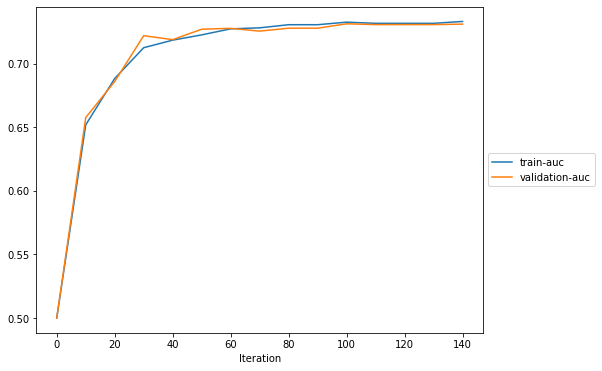

In [35]:
plot_collection(trial, "metrics")

SHAP
SHAP (SHapley Additive exPlanations) is another approach to explain the output of machine learning models. SHAP values represent a feature's contribution to a change in the model output. You instructed Estimator to log the average SHAP values in this example so the SHAP values (as calculated by xgboost.predict(pred_contribs=True)) will be available the average_shap collection.

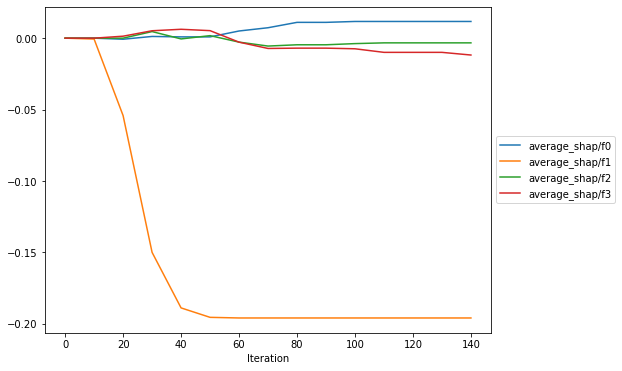

In [36]:
plot_collection(trial, "average_shap")

Global explanatory methods allow understanding the model and its feature contributions in aggregate over multiple datapoints. Here we show an aggregate bar plot that plots the mean absolute SHAP value for each feature.

The detailed summary plot below can provide more context over the above bar chart. It tells which features are most important and, in addition, their range of effects over the dataset. The color allows us to match how changes in the value of a feature effect the change in prediction.

The 'red' indicates higher value of the feature and 'blue' indicates lower (normalized over the features). This allows conclusions such as 'increase in age leads to higher log odds for prediction, eventually leading to True predictions more often.

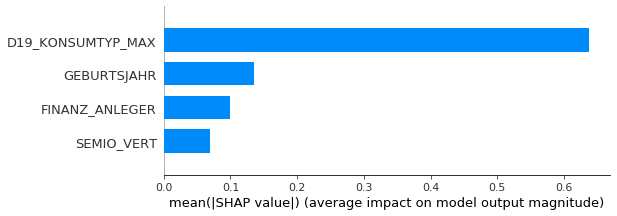

In [46]:
# !pip install shap
import shap
shap_values = trial.tensor("full_shap/f0").value(trial.last_complete_step)
shap_no_base = shap_values[:, :-1]
shap_base_value = shap_values[0, -1]
shap.summary_plot(shap_no_base, plot_type='bar', feature_names=features)

## Local explainability

Local explainability aims to explain model behavior for a fixed input point. This can be used for either auditing models before deployment or to provide explanations for specific inference predictions.

In [48]:
shap.initjs()

A force plot explanation shows how features are contributing to push the model output from the base value (the average model output over the dataset) to the model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue.

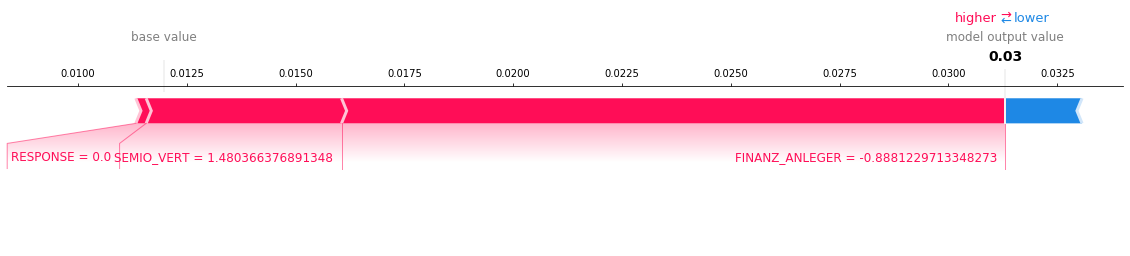

In [52]:
shap.force_plot(shap_base_value, shap_no_base[100, :],
                train.iloc[100, :-1], link="logit", matplotlib=True)

### Stacked force plot

In [53]:
import numpy as np
N_ROWS = shap_no_base.shape[0]
N_SAMPLES = min(100, N_ROWS)
sampled_indices = np.random.randint(N_ROWS, size=N_SAMPLES)

In [56]:
shap.force_plot(shap_base_value,
                shap_no_base[sampled_indices, :],
                train.iloc[sampled_indices, :-1],
                link='logit')

### Outliers

In [58]:
# top outliers
from scipy import stats
N_OUTLIERS = 3  # number of outliers on each side of the tail

shap_sum = np.sum(shap_no_base, axis=1)
z_scores = stats.zscore(shap_sum)
outlier_indices = (np.argpartition(z_scores, -N_OUTLIERS)
                   [-N_OUTLIERS:]).tolist()
outlier_indices += (np.argpartition(z_scores, N_OUTLIERS)
                    [:N_OUTLIERS]).tolist()

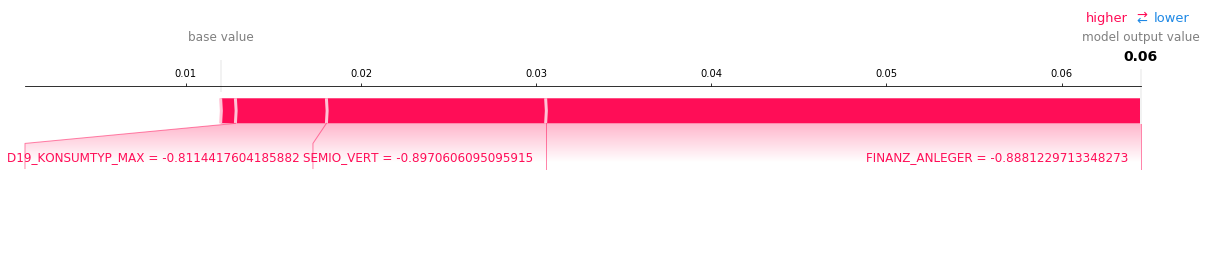

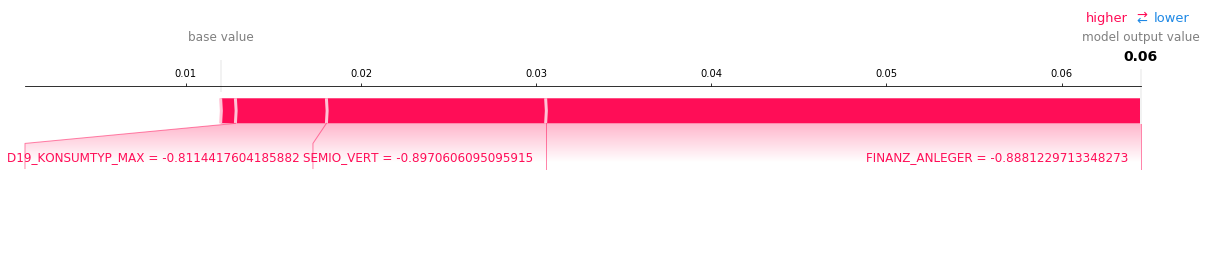

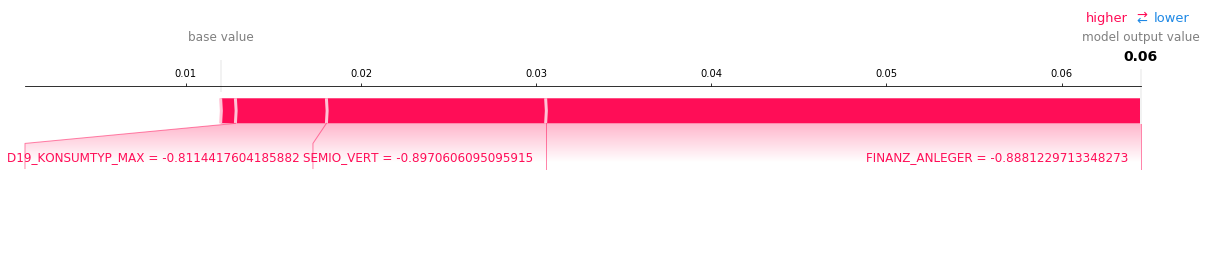

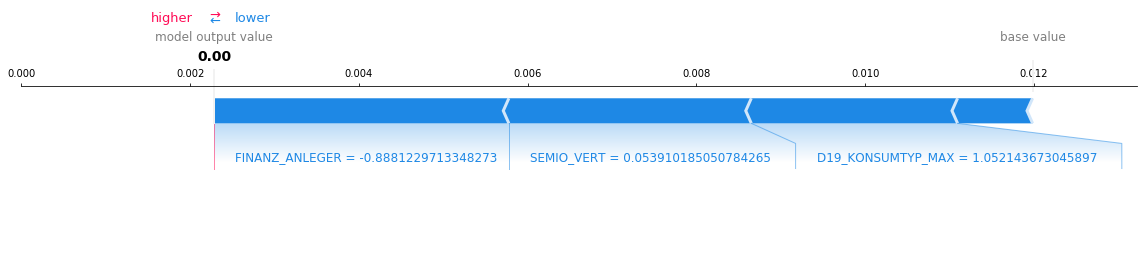

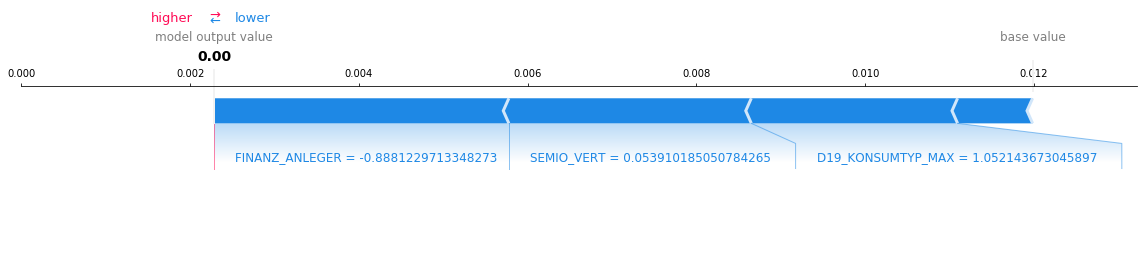

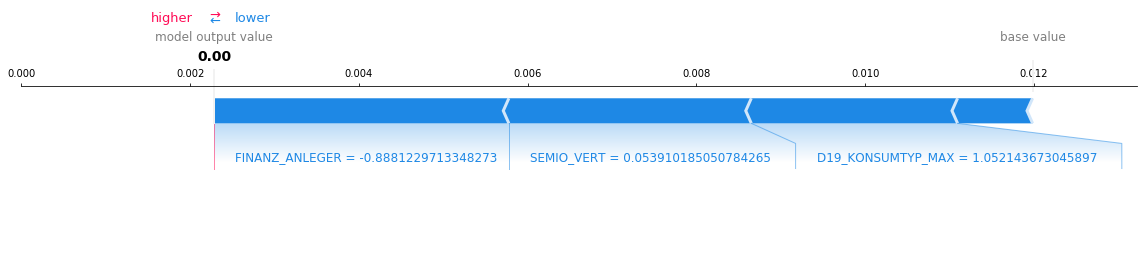

In [60]:
for fig_index, outlier_index in enumerate(outlier_indices, start=1):
    shap.force_plot(shap_base_value,
                    shap_no_base[outlier_index, :],
                    train.iloc[outlier_index, :-1],
                    matplotlib=True,
                    link='logit')

### Testing the model

In [ ]:
xgb_transformer = xgb.transformer(instance_count=1, instance_type='ml.m4.xlarge')

In [ ]:
xgb_transformer.transform(test_location, content_type='text/csv', split_type='Line')

In [ ]:
xgb_transformer.wait()

In [ ]:
!aws s3 cp --recursive $xgb_transformer.output_path 'dataset'

In [ ]:
model_file='s3://sagemaker-us-east-2-240038582877/supervised/output/sagemaker-xgboost-2020-05-26-04-25-15-059/output/model.tar.gz'
!aws s3 cp model_file

In [ ]:
predictions = pd.read_csv('dataset/test.csv.out', header=None)
predictions = [round(num) for num in predictions.squeeze().values]

In [ ]:
from sklearn.metrics import roc_auc_score, confusion_matrix
auc = roc_auc_score(Y_test, predictions)
tn, fp, fn, tp = confusion_matrix(Y_test, predictions).ravel()

In [ ]:
tn, fp, fn, tp

In [ ]:
auc

In [ ]:
confusion_matrix(Y_test, predictions).ravel()

In [ ]:
model_file='s3://sagemaker-us-east-2-240038582877/supervised/output/sagemaker-xgboost-2020-05-26-04-25-15-059/output/model.tar.gz'
 

In [ ]:
training_job_name = 'sagemaker-xgboost-2020-05-26-04-25-15-059'